# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.940039,False,-0.298641
1,1.086815,True,4.075165
2,-1.220538,False,-0.143013
3,0.486105,True,6.551593
4,-0.720150,False,-0.633260
...,...,...,...
995,0.237731,True,5.216732
996,-0.284079,False,1.280480
997,0.202021,False,-1.883945
998,0.644924,True,4.551402


<AxesSubplot: xlabel='v0'>

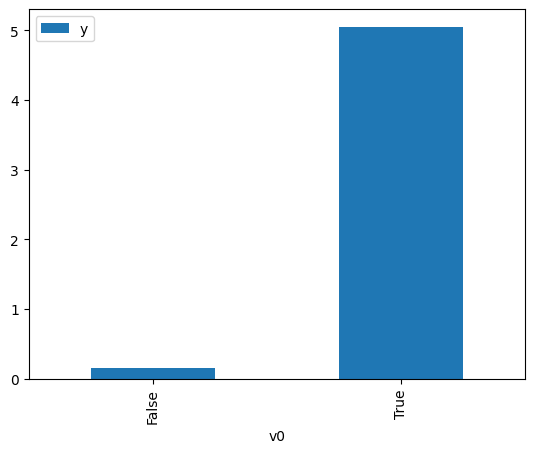

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

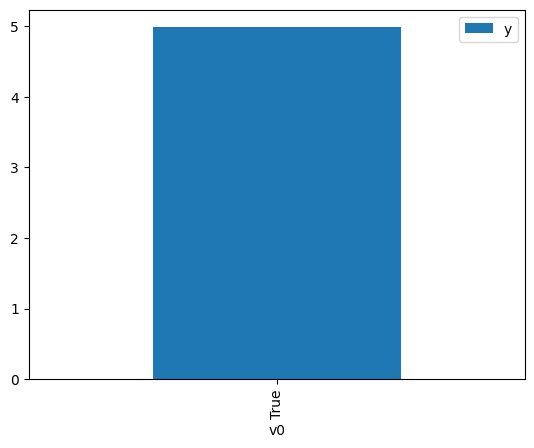

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.354961,False,0.106689,0.309432,3.231724
1,-0.214269,False,-0.228294,0.575484,1.737666
2,-0.174342,False,0.637775,0.556412,1.797230
3,0.318427,False,1.844750,0.324817,3.078657
4,-0.056742,False,0.735526,0.499476,2.002098
...,...,...,...,...,...
995,0.913356,False,0.206010,0.131388,7.611032
996,0.266959,False,0.330670,0.347141,2.880671
997,1.612503,False,-0.048735,0.037383,26.750113
998,0.859879,False,0.813663,0.143719,6.958015


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.206334,True,5.125158,0.096771,10.333669
1,1.167952,True,4.553549,0.915590,1.092192
2,-0.169965,True,6.223119,0.445690,2.243712
3,0.915932,True,6.255408,0.869182,1.150507
4,0.765186,True,4.523858,0.832099,1.201780
...,...,...,...,...,...
995,0.388908,True,5.366361,0.704495,1.419457
996,0.469485,True,5.768754,0.736043,1.358617
997,0.463109,True,7.083713,0.733626,1.363092
998,1.091852,True,5.819575,0.903425,1.106898


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.945
Model:                            OLS   Adj. R-squared (uncentered):              0.945
Method:                 Least Squares   F-statistic:                              8652.
Date:                Wed, 15 Mar 2023   Prob (F-statistic):                        0.00
Time:                        19:28:11   Log-Likelihood:                         -1418.3
No. Observations:                1000   AIC:                                      2841.
Df Residuals:                     998   BIC:                                      2850.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2295      0.038      6.082      0.000       0.155       0.304
x2             4.9446      0.051     96.056      0.000       4.844       5.046
==============================================================================
Omnibus:                        2.714   Durbin-Watson:                   1.955
Prob(Omnibus):                  0.257   Jarque-Bera (JB):                2.455
Skew:                          -0.046   Prob(JB):                        0.293
Kurtosis:                       2.775   Cond. No.                         2.33
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""